# Zillow's Home Value Prediction Exploratory Data Analysis

In [30]:
# required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from scipy import stats
import warnings
import time
from utils import *

# display set up
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 3)
sns.set_style('whitegrid')

## Load in Dataset

In [22]:
%%time
# Load in target data
df_2016 = load_data('data/train_2016_v2.csv')
df_2017 = load_data('data/train_2017.csv')

# Load in properties data
prop_2016 = load_data('data/properties_2016.csv')
prop_2017 = load_data('data/properties_2017.csv')
assert len(prop_2016) == len(prop_2017)
print("Number of properties: {}".format(len(prop_2016)))
print("Number of property features: {}".format(len(prop_2016.columns)-1))

Mem. usage decreased to  1.21 Mb (41.7% reduction)
Number of rows: 90275
Number of columns: 2 

Mem. usage decreased to  1.04 Mb (41.7% reduction)
Number of rows: 77613
Number of columns: 2 

Mem. usage decreased to 512.45 Mb (61.2% reduction)
Number of rows: 2985217
Number of columns: 57 

Mem. usage decreased to 512.45 Mb (61.2% reduction)
Number of rows: 2985217
Number of columns: 57 

Number of properties: 2985217
Number of property features: 57
CPU times: user 1min 13s, sys: 36 s, total: 1min 49s
Wall time: 2min 33s


## Data Exploration

In [24]:
# Merge Dataset
df_prop_2016 = pd.merge(df_2016,prop_2016,how='inner',on='parcelid')
df_prop_2017 = pd.merge(df_2017,prop_2017,how='inner',on='parcelid')

In [36]:
resumetable(df_prop_2016, df_prop_2016.columns).sample(10)

Dataset Shape: (90275, 60)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
44,threequarterbathnbr,float16,78266,86.697,4,NaN,1.0,NaN,0.07
42,roomcnt,float16,0,0.000,17,0.0,0.0,0.0,1.38
27,longitude,float32,0,0.000,57817,-118488536.0,-117677552.0,-118175032.0,15.29
57,taxdelinquencyflag,object,88492,98.025,1,NaN,NaN,NaN,0.00
33,pooltypeid7,float16,73578,81.504,1,NaN,NaN,NaN,0.00
18,finishedsquarefeet6,float32,89854,99.534,360,NaN,NaN,NaN,8.40
7,bedroomcnt,float16,0,0.000,17,3.0,4.0,2.0,2.18
24,hashottuborspa,object,87910,97.380,1,NaN,NaN,NaN,0.00
56,taxamount,float32,6,0.007,85110,6735.88,10153.02,11484.48,16.34
5,basementsqft,float16,90232,99.952,39,NaN,NaN,NaN,5.22


The target variable in this competition is the `logerror` term. Let's first do some visualization.

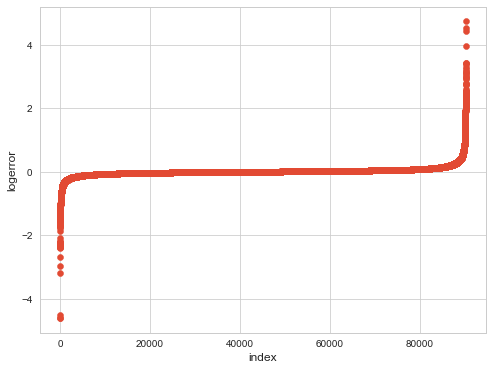

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(range(df_prop_2016.shape[0]), np.sort(df_prop_2016.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

We can clearly see that there are some outliers at both end. This is the target variable that we are going to predict. Let's now leave it here and take a look at the property dataset.

### Property Dataset

In [12]:
resume2016 = resumetable(df_prop_2016)
resume2017 = resumetable(df_prop_2017)

Dataset Shape: (90275, 60)
Dataset Shape: (77613, 60)


In [14]:
resume2016.sample(20)

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
48,yardbuildingsqft26,float16,90180,99.895,73,NaN,NaN,NaN,6.02
3,airconditioningtypeid,float16,61494,68.119,6,1.0,NaN,1.0,0.43
16,finishedsquarefeet15,float16,86711,96.052,1614,NaN,NaN,NaN,10.33
1,logerror,float16,0,0.000,1890,0.028,-0.168,-0.004,8.31
21,fullbathcnt,float16,1182,1.309,14,2.0,3.0,3.0,1.83
5,basementsqft,float16,90232,99.952,39,NaN,NaN,NaN,5.22
13,calculatedfinishedsquarefeet,float16,661,0.732,3408,1684.0,2264.0,2216.0,11.05
23,garagetotalsqft,float16,60338,66.838,870,NaN,468.0,NaN,6.27
8,buildingclasstypeid,float16,90259,99.982,1,NaN,NaN,NaN,0.00
10,calculatedbathnbr,float16,1182,1.309,22,2.0,3.5,3.0,2.38


In [286]:
@timeit
def mappingfunc(series, mapping, na_string=False):
    mapped = series.map(mapping, na_action='ignore')
    if na_string:
        mapped = mapped.fillna(value = na_string)
    print(mapped.value_counts())
    print('-------------------')
    if mapped.isna().sum() != 0:
        print(f'{mapped.isna().sum() / len(series) * 100}% of values are still NaN.')
    else:
        print('There is no missing values in this series anymore.')
    return(mapped)

### Air Conditioning

From the data dictionary file we can see that missing values imply that there is no cooling system in the house. Therefore, we can simply impute **None** that means no air conditioning. Since this is a pure categorical variable, for explanability, let's also decode the number into its actual type of air conditioning system.

In [335]:
compare_value_counts('airconditioningtypeid')

6 unique values for feature "airconditioningtypeid": [1.0, 3.0, 5.0, 9.0, 11.0, 13.0]


,1.0,3.0,5.0,9.0,11.0,13.0
airconditioningtypeid,26668,1.0,215,1,63,1833
airconditioningtypeid,23186,NaN,167,26,53,1575


In [337]:
mapping = {1.0: 'Central', 3.0: 'Evaporative Cooler', 5.0: np.nan, 9.0: 'Refrigeration',
          11.0: 'Wall Unit', 13.0: 'Unknown Type'}

df_prop_2016.airconditioningtypeid = mappingfunc(df_prop_2016.airconditioningtypeid, mapping, 'No Airconditioning')
df_prop_2017.airconditioningtypeid = mappingfunc(df_prop_2017.airconditioningtypeid, mapping, 'No Airconditioning')

No Airconditioning    61709
Central               26668
Unknown Type           1833
Wall Unit                63
Evaporative Cooler        1
Refrigeration             1
Name: airconditioningtypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 23.64 ms
No Airconditioning    52773
Central               23186
Unknown Type           1575
Wall Unit                53
Refrigeration            26
Name: airconditioningtypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 17.82 ms


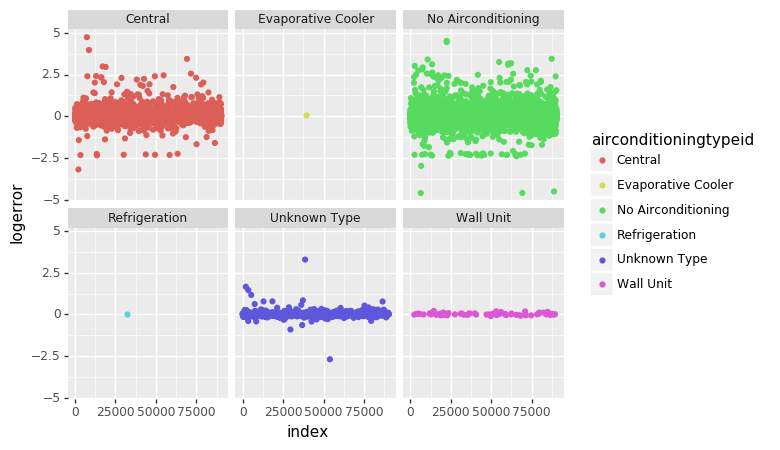

<ggplot: (283914033)>

In [338]:
df_prop_2016['index'] = range(df_prop_2016.shape[0])

ggplot() + geom_point(mapping=aes(x = 'index', y = 'logerror', color = 'airconditioningtypeid'), data=df_prop_2016) + \
facet_wrap(facets='airconditioningtypeid')

**Fun Facts**:

1. Most of the data point have logerror values close to zero. For example, **Refrigeration, Evaporative Cooler, and Wall Unit**.

2. Two types of air conditioning system, **Central and No Airconditioning**, tend to have more errors.

3. For **Unknown Types**, it tends to be in the middle.

Here let's encode it into three types: **Central**, **No Airconditioning**, **Unknown Type**, and **Others**.

In [19]:
# mapping = {'Central': 'Central', 'Evaporative Cooler': "Others", 'Refrigeration': "Others",
#           'Wall Unit': "Others", 'Window Unit': "Others", 'Unknown Type': "Unknown Type", 
#            "No Airconditioning": "No Airconditioning"}

# df_prop_2016.airconditioningtypeid = mappingfunc(df_prop_2016.airconditioningtypeid, mapping)
# df_prop_2017.airconditioningtypeid = mappingfunc(df_prop_2017.airconditioningtypeid, mapping)

In [339]:
cat_list = []
cat_list.append('airconditioningtypeid')

---
### Transaction Date

In [368]:
resume2016.query(f'Name == "transactiondate"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
2,transactiondate,object,0,0.0,352,2016-01-01,2016-01-01,2016-01-01,7.84


For transaction date, let's see the relationship bewteen log error and transaction date.

In [341]:
# convert strings to date object
df_prop_2016.transactiondate = df_prop_2016.transactiondate.apply(lambda x: pd.to_datetime(x))
df_prop_2017.transactiondate = df_prop_2017.transactiondate.apply(lambda x: pd.to_datetime(x))

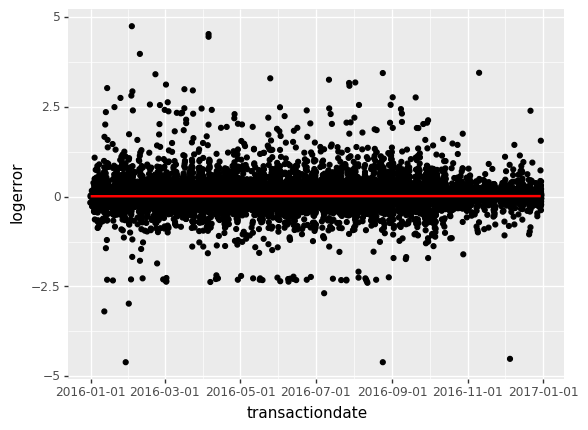

<ggplot: (7085176601)>

In [410]:
plot_scatter(df_prop_2016, 'transactiondate', 'logerror')

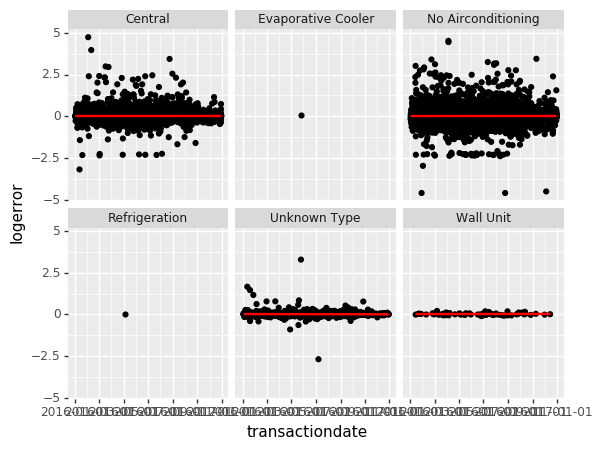

<ggplot: (7181222777)>

In [413]:
plot_scatter(df_prop_2016, 'transactiondate', 'logerror', 'airconditioningtypeid')

We can't see much different compared to previous plot. This is because in reality this dataframe is somewhat ordered by the transaction datetime. That is, the order of index is the same as the order of transaction datetime. Thus, the plot looks the same. Also here we add a regression line onto the plot. We can see that for all airconditioning type, transaction time has no relationship with logerror.

---
### Architectural Style Type

In [367]:
resume2016.query(f'Name == "architecturalstyletypeid"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
4,architecturalstyletypeid,float16,90014,99.711,6,NaN,NaN,NaN,0.92


In [345]:
compare_value_counts('architecturalstyletypeid')

6 unique values for feature "architecturalstyletypeid": [2.0, 3.0, 7.0, 8.0, 10.0, 21.0]


,2.0,3.0,7.0,8.0,10.0,21.0
architecturalstyletypeid,11,4,221,16,1.0,8
architecturalstyletypeid,5,3,173,19,NaN,7


In [346]:
mapping = {2.0: 'Bungalow', 3.0: 'Cape Cod', 7.0: 'Contemporary', 8.0: 'Conventional',
          10.0: 'French Provincial', 21.0: 'Ranch/Rambler'}

df_prop_2016.architecturalstyletypeid = mappingfunc(df_prop_2016.architecturalstyletypeid, mapping, 'MissingValue')
df_prop_2017.architecturalstyletypeid = mappingfunc(df_prop_2017.architecturalstyletypeid, mapping, 'MissingValue')

MissingValue         90014
Contemporary           221
Conventional            16
Bungalow                11
Ranch/Rambler            8
Cape Cod                 4
French Provincial        1
Name: architecturalstyletypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 21.07 ms
MissingValue     77406
Contemporary       173
Conventional        19
Ranch/Rambler        7
Bungalow             5
Cape Cod             3
Name: architecturalstyletypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 17.17 ms


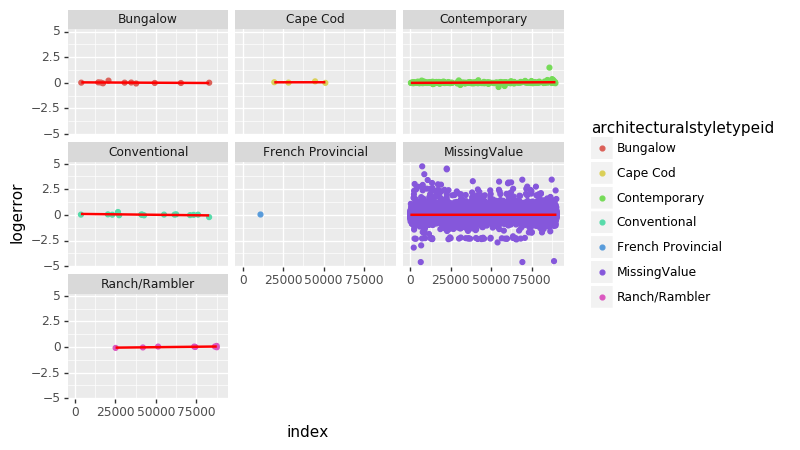

<ggplot: (7030496825)>

In [415]:
plot_scatter(df_prop_2016, 'index', 'logerror', 'architecturalstyletypeid')

In this column we can get some insights.

There are lots of missing values here (~99.7%). So practically one good method is to drop this column. However, we can see that is the architectural style is missing, the logerror metrics tend to fluctuate quite a lot. When this style is set, it tends to be somewhat close to zero. Therefore, we can probably say that missing this value can cause huge discretion beteen the prediction and the actual sales price, thus making the range of logerror expand.

For now, since there's too many missing values, let's put it into our drop list.

In [348]:
drop_list = []
drop_list.append('architecturalstyletypeid')


---
### Basement Square Feet

In [369]:
resume2016.query(f'Name == "basementsqft"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
5,basementsqft,float16,90232,99.952,39,NaN,NaN,NaN,5.22


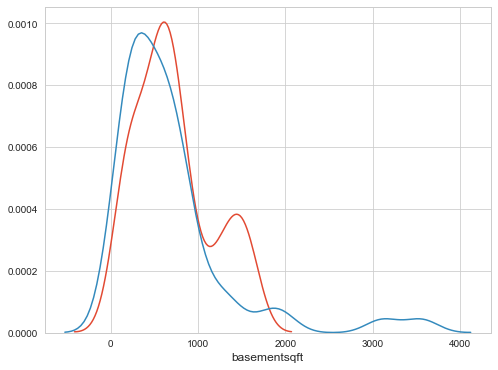

In [383]:
plot_distribution('basementsqft')

Let's see the relationship bewteen basementsqft and logerror

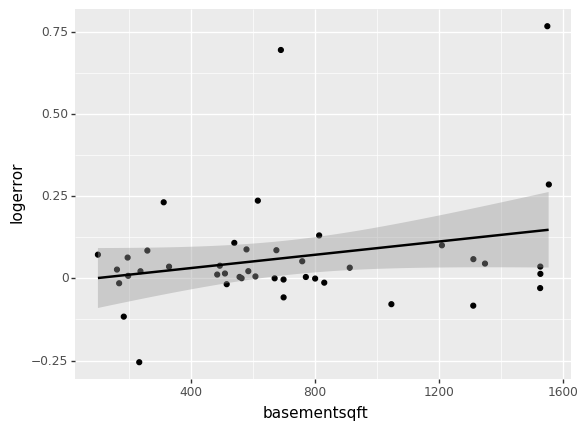

<ggplot: (7085089385)>

In [418]:
plot_scatter(df_prop_2016[df_prop_2016.basementsqft.notna()], 'basementsqft', 'logerror')

**Fun facts**:

1. All the rooms with basementsqft stated are with no airconditioning! 


2. When the basement square feet gets larger, logerror tends to increase. That is, when basementsqft is small, Zestimate tends to fit the actual price bettet than the value is large. We can see when basementsqft increases, the logerror value also increases, showing that Zestimate tends to increase faster. We can say that **Zestimate may overestimate the importance of basement squared foot on actual sales price.**

It seems that this information is useful in our prediction. However, since there are too many missing values, it needs to be imputed before being used. Thus, let's add this into our inpute_list.


---
### Bathroom Count

In [370]:
resume2016.query(f'Name == "bathroomcnt"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
6,bathroomcnt,float16,0,0.0,23,2,3.5,3,2.45


In [395]:
resume2017.query(f'Name == "bathroomcnt"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
6,bathroomcnt,float16,34,0.044,22,3.5,1,2,2.43


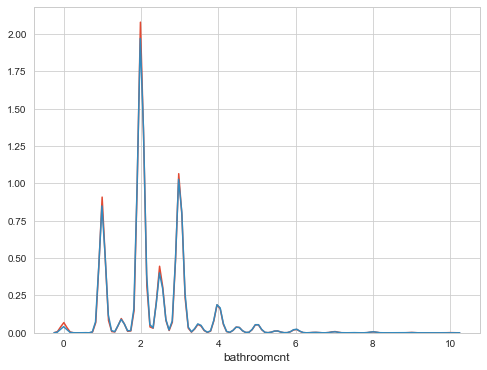

In [384]:
plot_distribution('bathroomcnt')

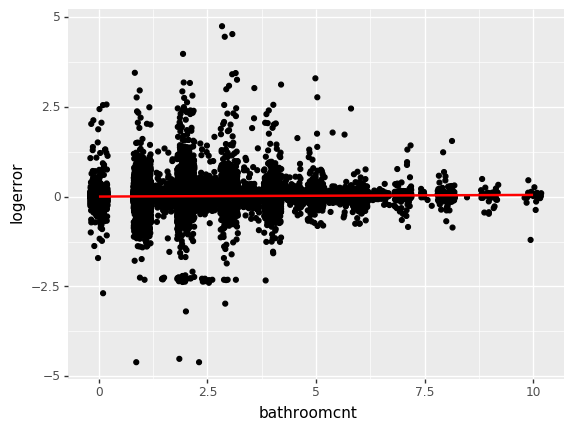

<ggplot: (7024425245)>

In [422]:
df_prop_2016.bathroomcnt = df_prop_2016.bathroomcnt.astype(float)
df_prop_2017.bathroomcnt = df_prop_2017.bathroomcnt.astype(float)

plot_scatter(df_prop_2016, 'bathroomcnt', 'logerror')

**Fun Facts**: The logerror for lower bathroom count homes tend to fluctuate more compared to rooms with higher bathroom counts.

---
### Badroom Count

In [393]:
resume2016.query(f'Name == "bedroomcnt"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
7,bedroomcnt,float16,34,0.044,16,4,2,3,2.17


In [394]:
resume2017.query(f'Name == "bedroomcnt"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
7,bedroomcnt,float16,34,0.044,16,4,2,3,2.17


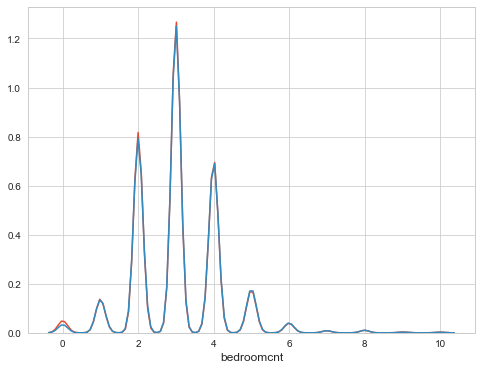

In [386]:
plot_distribution('bedroomcnt')

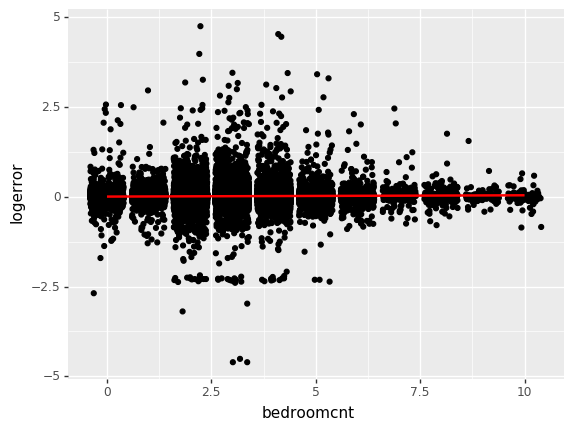

<ggplot: (7212136013)>

In [423]:
df_prop_2016.bedroomcnt = df_prop_2016.bedroomcnt.astype(float)
df_prop_2017.bedroomcnt = df_prop_2017.bedroomcnt.astype(float)

plot_scatter(df_prop_2016, 'bedroomcnt', 'logerror')

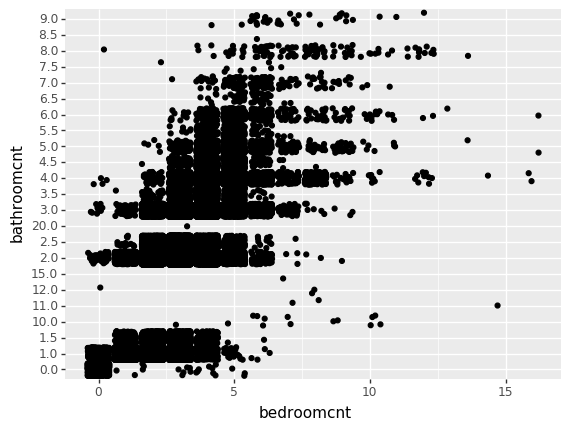

<ggplot: (7148142537)>

In [357]:
ggplot(aes(x = 'bedroomcnt', y = 'bathroomcnt'), data=df_prop_2016) + geom_jitter()

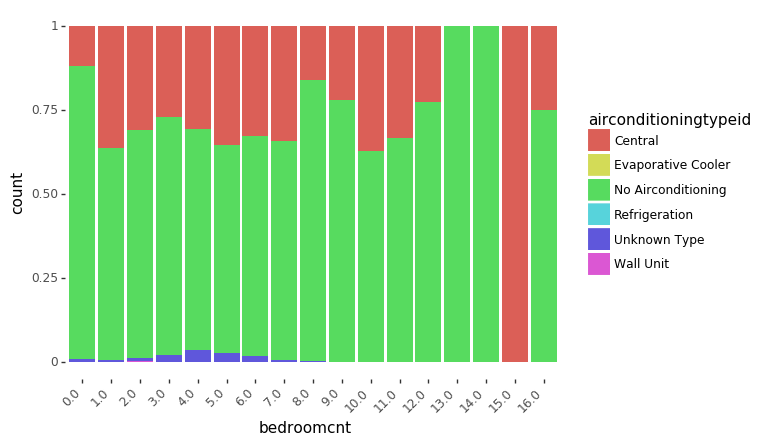

<ggplot: (7199508085)>

In [358]:
df_prop_2016.bedroomcnt = df_prop_2016.bedroomcnt.astype('str')
df_prop_2017.bedroomcnt = df_prop_2017.bedroomcnt.astype('str')

ggplot() + geom_bar(aes(x = 'bedroomcnt', fill='airconditioningtypeid'), data=df_prop_2016, position ='fill') + \
 theme(axis_text_x = element_text(angle = 45, hjust = 1), 
       panel_background=element_blank()) + \
scale_x_discrete(limits = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0',
                           '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0',
                           '14.0', '15.0', '16.0'])

**Fun Facts**:

1. Bedroom count has no relationship with type of air conditioning used.

2. The more bedroom, the more bathroom, which is quite reasonable.

Also both bedroom count and bathroom count have the same characteristic. There are some outliers for both of the feature. Here let's try to cap those outliers into at most 10.

In [359]:
df_prop_2016.bedroomcnt = df_prop_2016.bedroomcnt.astype(float)
df_prop_2016.bathroomcnt = df_prop_2016.bathroomcnt.astype(float)
df_prop_2016.loc[df_prop_2016.bedroomcnt > 10.0, 'bedroomcnt'] = 10.0
df_prop_2016.loc[df_prop_2016.bathroomcnt > 10.0, 'bathroomcnt'] = 10.0

df_prop_2017.bedroomcnt = df_prop_2017.bedroomcnt.astype(float)
df_prop_2017.bathroomcnt = df_prop_2017.bathroomcnt.astype(float)
df_prop_2017.loc[df_prop_2017.bedroomcnt > 10.0, 'bedroomcnt'] = 10.0
df_prop_2017.loc[df_prop_2017.bathroomcnt > 10.0, 'bathroomcnt'] = 10.0

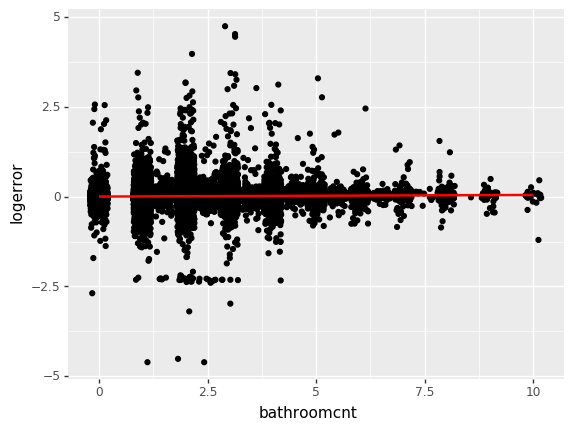

<ggplot: (7219549981)>

In [424]:
plot_scatter(df_prop_2016, 'bathroomcnt', 'logerror')

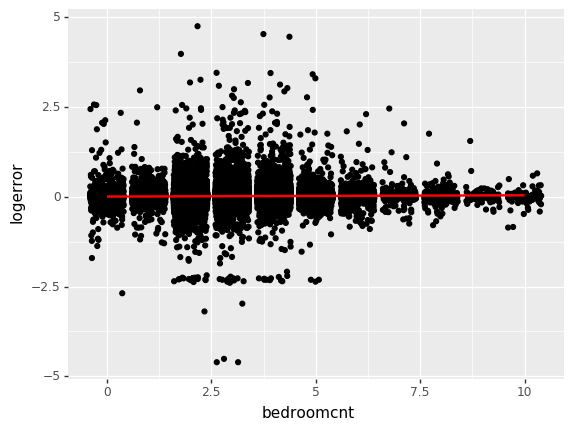

<ggplot: (7154579777)>

In [425]:
plot_scatter(df_prop_2016, 'bedroomcnt', 'logerror')

---

### Building Class Type

In [428]:
resume2016.query(f'Name == "buildingclasstypeid"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
8,buildingclasstypeid,float16,90259,99.982,1,NaN,NaN,NaN,0.0


We can see that there are only one unique values, and with 99.982% missing. Let's see whether those non-missing values tells us something interesting.

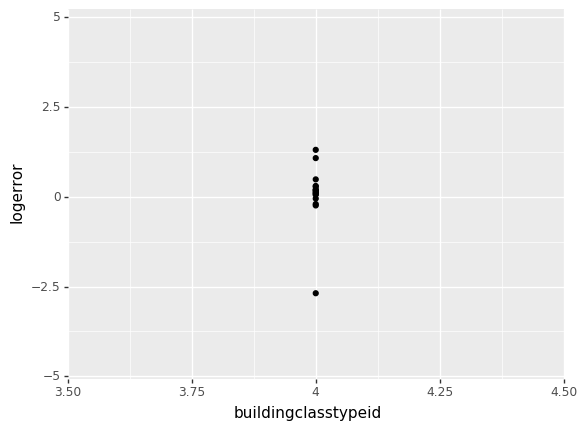

<ggplot: (7176623813)>

In [363]:
ggplot() + geom_point(aes(x='buildingclasstypeid', y='logerror'), data=df_prop_2016, na_rm=True) 

There is only 16 rows with buildingclasstypeid in 2016 and 15 in 2017. Although from the plot we can see the logerror is significantly away from 0, which might be an important signal for the prediction for logerror, since there are too many empty values this column might not have much information. Thus, let's add it into the drop list.

In [399]:
drop_list.append('buildingclasstypeid')

---
### Building Quality Type

In [400]:
resume2016.query(f'Name == "buildingqualitytypeid"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
9,buildingqualitytypeid,float16,32911,36.456,8,4,NaN,4,1.38


In [401]:
resume2017.query(f'Name == "buildingqualitytypeid"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
9,buildingqualitytypeid,float16,27804,35.824,12,NaN,NaN,NaN,2.48


In [402]:
compare_value_counts('buildingqualitytypeid')

12 unique values for feature "buildingqualitytypeid": [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
buildingqualitytypeid,2627,NaN,NaN,23839,NaN,2,29310,5,NaN,1461,1,119
buildingqualitytypeid,26,9.0,335.0,9508,2099.0,13501,5981,14685,2303.0,313,933,116


There are some serious distribution difference between the two dataset!

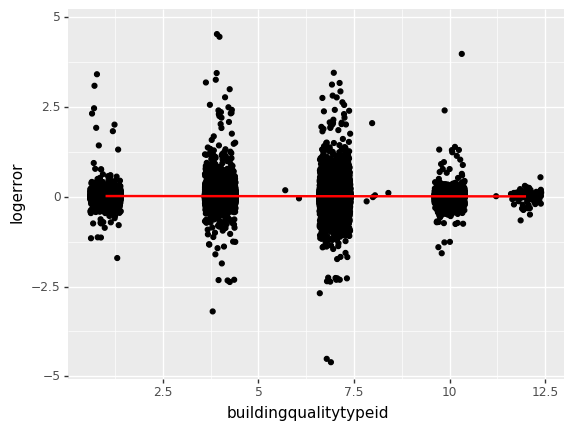

<ggplot: (7210273525)>

In [429]:
plot_scatter(df_prop_2016, 'buildingqualitytypeid', 'logerror')

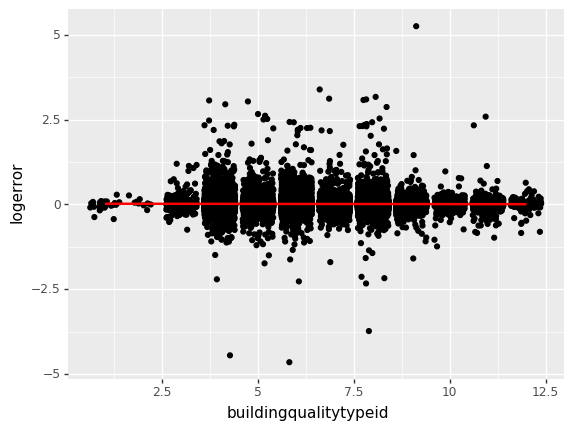

<ggplot: (7181460661)>

In [430]:
plot_scatter(df_prop_2017, 'buildingqualitytypeid', 'logerror')

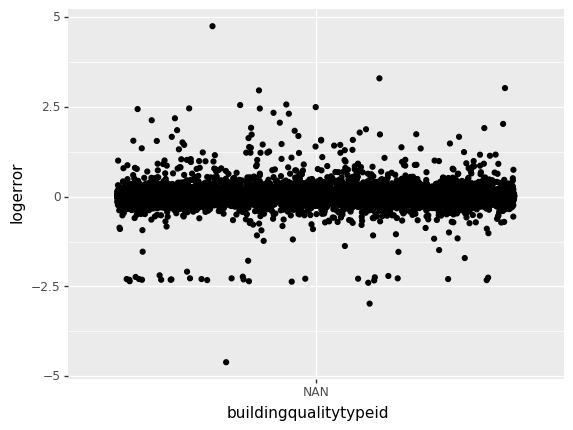

<ggplot: (7181370181)>

In [431]:
_ = df_prop_2016[df_prop_2016.buildingqualitytypeid.isna()].fillna('NAN')
plot_scatter(_, 'buildingqualitytypeid', 'logerror')

We can see that the relationship between building quality and logerror is almost undetectable. Though some building quaility type has larger range of logerror, they all basically center around 0.

From the data dictionary it states that this feature demonstrates the overall assessment of condition of the building from best (lowest) to worst (highest). That is, 1.0 is the best and 12.0 is the worst. Since there's no other information regarding how this feature can be used, let's treat it as a categorical value. 

In the meantime, we can see that some values have only little amount of data. Let's make it simply into 5 groups, putting 8.0 and 6.0 into 7.0 and 11.0, 12.0 into 10.0.

In [52]:
mapping = {1.0: 'best', 2.0: 'best', 3.0: 'best', 4.0: 'upper', 5.0: 'upper', 6.0: 'upper', 7.0: 'lower', 
           8.0: 'lower', 9.0: 'lower', 10.0: 'lowest', 11.0: 'lowest', 12.0: 'lowest'}

df_prop_2016.buildingqualitytypeid = mappingfunc(df_prop_2016.buildingqualitytypeid, mapping, 'MissingValue')
df_prop_2017.buildingqualitytypeid = mappingfunc(df_prop_2017.buildingqualitytypeid, mapping, 'MissingValue')

MissingValue    32911
lower           29315
upper           23841
best             2627
lowest           1581
Name: buildingqualitytypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 23.79 ms
MissingValue    27804
upper           25108
lower           22969
lowest           1362
best              370
Name: buildingqualitytypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 20.15 ms


In [53]:
cat_list.append('buildingqualitytypeid')

---
### Calculated Bath 

In the dictionary this feature has the same definition to bathroomcnt. Let's see what's the difference.

In [433]:
resume2016.query(f'Name == "calculatedbathnbr"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
10,calculatedbathnbr,float16,1182,1.309,22,2,3.5,3,2.38


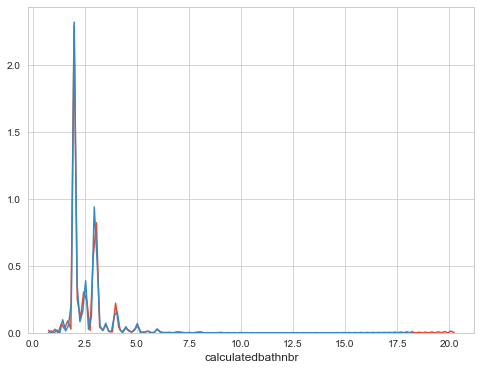

In [434]:
plot_distribution('calculatedbathnbr')

In [55]:
df_prop_2016[~(df_prop_2016.calculatedbathnbr == df_prop_2016.bathroomcnt)][['calculatedbathnbr','bathroomcnt']]

,calculatedbathnbr,bathroomcnt
126,NaN,0.0
174,NaN,0.0
231,NaN,0.0
293,NaN,0.0
299,NaN,0.0
...,...,...
89742,NaN,0.0
89752,NaN,0.0
89840,NaN,0.0
89895,NaN,0.0


We can see that Null value indicates 0.0. Here we can confidently drop this column.

In [56]:
drop_list.append('calculatedbathnbr')

---
### Deck Type

The definition of this feature: **Type of deck (if any) present on parcel**

In [444]:
resume2016.query(f'Name == "decktypeid"')

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
11,decktypeid,float16,89617,99.271,1,NaN,NaN,NaN,0.0


In [443]:
df_prop_2016.decktypeid.unique()

array([nan, 66.], dtype=float16)

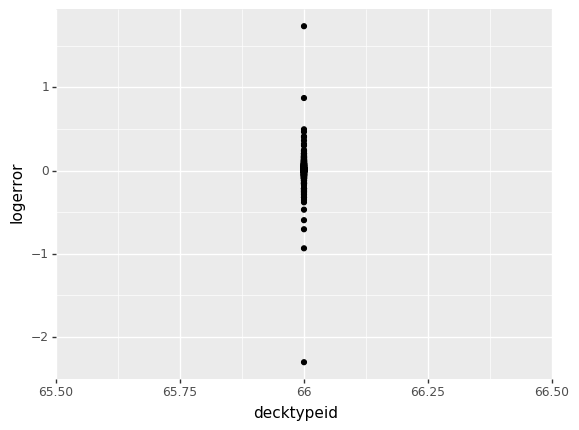

<ggplot: (7037939621)>

In [60]:
ggplot() + geom_point(aes(x = 'decktypeid', y = 'logerror'), data=df_prop_2016[df_prop_2016.decktypeid.notna()])

Still we can see there's not much information about this. Let's drop this feature.

In [61]:
drop_list.append('decktypeid')

---
### Square Fit

In [446]:
resume2016.iloc[12:19]

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
12,finishedfloor1squarefeet,float16,83419,92.405,1799,NaN,NaN,NaN,10.34
13,calculatedfinishedsquarefeet,float16,661,0.732,3408,1.68e+03,2.26e+03,2.22e+03,11.05
14,finishedsquarefeet12,float16,4679,5.183,3382,1.68e+03,2.26e+03,2.22e+03,11.03
15,finishedsquarefeet13,float16,90242,99.963,11,NaN,NaN,NaN,2.53
16,finishedsquarefeet15,float16,86711,96.052,1614,NaN,NaN,NaN,10.33
17,finishedsquarefeet50,float16,83419,92.405,1809,NaN,NaN,NaN,10.35
18,finishedsquarefeet6,float16,89854,99.534,347,NaN,NaN,NaN,8.33


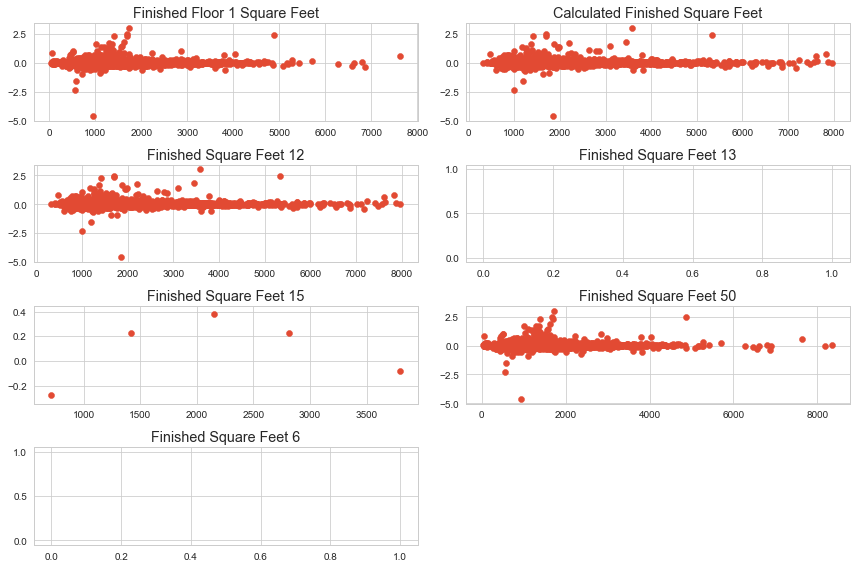

In [447]:
_ = df_prop_2016[df_prop_2016.finishedfloor1squarefeet.notna()]
plt.figure(figsize=(12,8))
plt.subplot(421)
plt.scatter(_.finishedfloor1squarefeet, _.logerror)
plt.title('Finished Floor 1 Square Feet')

plt.subplot(422)
plt.scatter(_.calculatedfinishedsquarefeet, _.logerror)
plt.title('Calculated Finished Square Feet')

plt.subplot(423)
plt.scatter(_.finishedsquarefeet12, _.logerror)
plt.title('Finished Square Feet 12')

plt.subplot(424)
plt.scatter(_.finishedsquarefeet13, _.logerror)
plt.title('Finished Square Feet 13')

plt.subplot(425)
plt.scatter(_.finishedsquarefeet15, _.logerror)
plt.title('Finished Square Feet 15')

plt.subplot(426)
plt.scatter(_.finishedsquarefeet50, _.logerror)
plt.title('Finished Square Feet 50')

plt.subplot(427)
plt.scatter(_.finishedsquarefeet6, _.logerror)
plt.title('Finished Square Feet 6')

plt.tight_layout()

---

### FIPS

Definition: **Federal Information Processing Standard code**

In [64]:
df_prop_2016.fips.value_counts()

6036.0    58574
6060.0    24505
6112.0     7196
Name: fips, dtype: int64

In [65]:
df_prop_2017.fips.value_counts()

6036.0    50696
6060.0    20631
6112.0     6252
Name: fips, dtype: int64

In [66]:
df_prop_2016.fips = df_prop_2016.fips.replace(6036.0,'Code1').replace(6060.0,'Code2').replace(6112.0,'Code3')
df_prop_2017.fips = df_prop_2017.fips.replace(6036.0,'Code1').replace(6060.0,'Code2').replace(6112.0,'Code3')

In [67]:
cat_list.append('fips')

---
### Fireplace Count

Definition: **Number of fireplaces in a home (if any)**

In [68]:
df_prop_2016.fireplacecnt.value_counts()

1.0    8165
2.0    1106
3.0     312
4.0      21
5.0       3
Name: fireplacecnt, dtype: int64

In [69]:
df_prop_2017.fireplacecnt.value_counts()

1.0    7018
2.0     998
3.0     235
4.0      35
5.0       3
Name: fireplacecnt, dtype: int64

In [70]:
df_prop_2016.fireplacecnt = df_prop_2016.fireplacecnt.replace(np.nan, 0)
df_prop_2017.fireplacecnt = df_prop_2017.fireplacecnt.replace(np.nan, 0)

---
## Fastforward EDA

In [453]:
resume2016[(resume['dtypes'] == np.float16) | (resume['dtypes'] == np.float32)].iloc[19:]

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
21,fullbathcnt,float16,1182,1.309,14,2,3,3,1.83
22,garagecarcnt,float16,60338,66.838,15,NaN,2,NaN,1.09
23,garagetotalsqft,float16,60338,66.838,870,NaN,468,NaN,6.27
25,heatingorsystemtypeid,float16,34195,37.879,12,2,NaN,2,1.14
26,latitude,float32,0,0.000,63620,3.43e+07,3.37e+07,3.41e+07,15.64
27,longitude,float32,0,0.000,57817,-1.18e+08,-1.18e+08,-1.18e+08,15.29
28,lotsizesquarefeet,float32,10150,11.243,20016,7.53e+03,3.64e+03,1.14e+04,13.23
29,poolcnt,float16,72374,80.171,1,NaN,NaN,NaN,0.00
30,poolsizesum,float16,89306,98.927,273,NaN,NaN,NaN,6.81
31,pooltypeid10,float16,89114,98.714,1,NaN,NaN,NaN,0.00


In [73]:
drop_list.extend(['fullbathcnt','censustractandblock','typeconstructiontypeid','assessmentyear'])

### Regional label

In this dataset there are lots of regional label. Since there are too many types, here I'll only use regionidcounty to represent to influece by region.

In [74]:
embed_list = []
embed_list.extend(['regionidcity','regionidzip', 'latitude','longitude','rawcensustractandblock'])
drop_list.extend(['regionidneighborhood'])

In [75]:
df_prop_2016.regionidcounty.value_counts()

3100.0    58574
1286.0    24505
2060.0     7196
Name: regionidcounty, dtype: int64

In [76]:
df_prop_2017.regionidcounty.value_counts()

3100.0    50696
1286.0    20631
2060.0     6252
Name: regionidcounty, dtype: int64

In [77]:
mapping = {3100.0: 'County1', 1286.0: 'County2', 2060.0: 'County3'}

df_prop_2016.regionidcounty = mappingfunc(df_prop_2016.regionidcounty, mapping)
df_prop_2017.regionidcounty = mappingfunc(df_prop_2017.regionidcounty, mapping, 'MissingValue')

County1    58574
County2    24505
County3     7196
Name: regionidcounty, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 15.91 ms
County1         50696
County2         20631
County3          6252
MissingValue       34
Name: regionidcounty, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 18.67 ms


In [78]:
cat_list.append('regionidcounty')

### Heating or System Type

In [79]:
df_prop_2016.heatingorsystemtypeid.value_counts()

2.0     38303
7.0     15519
24.0     1071
6.0       970
20.0       97
13.0       76
18.0       25
1.0        13
14.0        2
10.0        2
11.0        1
12.0        1
Name: heatingorsystemtypeid, dtype: int64

In [80]:
df_prop_2017.heatingorsystemtypeid.value_counts()

2.0     33633
7.0     14107
24.0      850
6.0       777
20.0      104
13.0       60
18.0       23
1.0        13
10.0        3
11.0        1
Name: heatingorsystemtypeid, dtype: int64

In [81]:
mapping = {1.0: 'Baseboard', 2.0: 'Central', 6.0: 'Forced air', 7.0: 'Floor/Wall', 10.0: 'Other', 11.0: 'Other',
           12.0: 'Other', 13.0: 'None', 14.0: 'Other', 18.0: 'Radiant', 20.0: 'Other', 24.0: 'Some Type'}

df_prop_2016.heatingorsystemtypeid = mappingfunc(df_prop_2016.heatingorsystemtypeid, mapping, 'MissingValue')
df_prop_2017.heatingorsystemtypeid = mappingfunc(df_prop_2017.heatingorsystemtypeid, mapping, 'MissingValue')

Central         38303
MissingValue    34195
Floor/Wall      15519
Some Type        1071
Forced air        970
Other             103
None               76
Radiant            25
Baseboard          13
Name: heatingorsystemtypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 28.13 ms
Central         33633
MissingValue    28042
Floor/Wall      14107
Some Type         850
Forced air        777
Other             108
None               60
Radiant            23
Baseboard          13
Name: heatingorsystemtypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 18.12 ms


In [82]:
cat_list.append('heatingorsystemtypeid')

### Property Land Use Type

In [83]:
df_prop_2016.propertylandusetypeid.value_counts()

261.0    60637
266.0    22815
246.0     2376
269.0     2334
248.0      879
247.0      629
265.0      356
263.0       84
260.0       62
275.0       46
267.0       28
31.0        17
264.0       11
47.0         1
Name: propertylandusetypeid, dtype: int64

In [84]:
df_prop_2017.propertylandusetypeid.value_counts()

261.0    52441
266.0    19342
246.0     2021
269.0     1947
248.0      729
247.0      539
265.0      335
263.0       74
275.0       59
260.0       42
267.0       29
31.0        15
264.0        6
Name: propertylandusetypeid, dtype: int64

In [85]:
mapping = {261.0: 'Single Family Residential', 266.0: 'Condominium', 246.0: 'Duplex', 
           269.0: 'Planned Unit Development', 248.0: 'Quadruplex', 247.0: 'Triplex', 
           265.0: 'Cluster Home', 263.0: 'Mobile Home', 260.0: 'Residential General', 
           275.0: 'Manufactured, Modular, Prefabricated Homes', 267.0: 'Cooperative',
           31.0: 'Commercial/Office/Residential Mixed Used', 264.0:'Townhouse', 
           47.0: 'Commercial/Office/Residential Mixed Used'}

df_prop_2016.propertylandusetypeid = mappingfunc(df_prop_2016.propertylandusetypeid, mapping, 'MissingValue')
df_prop_2017.propertylandusetypeid = mappingfunc(df_prop_2017.propertylandusetypeid, mapping, 'MissingValue')

Single Family Residential                     60637
Condominium                                   22815
Duplex                                         2376
Planned Unit Development                       2334
Quadruplex                                      879
Triplex                                         629
Cluster Home                                    356
Mobile Home                                      84
Residential General                              62
Manufactured, Modular, Prefabricated Homes       46
Cooperative                                      28
Commercial/Office/Residential Mixed Used         18
Townhouse                                        11
Name: propertylandusetypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 18.99 ms
Single Family Residential                     52441
Condominium                                   19342
Duplex                                        

In [86]:
cat_list.append('propertylandusetypeid')

### Story Type

In [87]:
df_prop_2016.storytypeid.value_counts()

7.0    43
Name: storytypeid, dtype: int64

In [88]:
df_prop_2017.storytypeid.value_counts()

7.0    50
Name: storytypeid, dtype: int64

In [89]:
mapping = {7.0: 'Basement'}

df_prop_2016.storytypeid = mappingfunc(df_prop_2016.storytypeid, mapping, 'Not Basement')
df_prop_2017.storytypeid = mappingfunc(df_prop_2017.storytypeid, mapping, 'Not Basement')

Not Basement    90232
Basement           43
Name: storytypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 64.25 ms
Not Basement    77563
Basement           50
Name: storytypeid, dtype: int64
-------------------
There is no missing values in this series anymore.
----------------------
Function 'mappingfunc' takes 15.93 ms


In [90]:
cat_list.append('storytypeid')

### Pools

In [91]:
l = ['poolcnt','pooltypeid10','pooltypeid2','pooltypeid7']
for col in l:
    df_prop_2016[col] = df_prop_2016[col].apply(lambda x: 1 if x == 1 else 0)
    df_prop_2017[col] = df_prop_2017[col].apply(lambda x: 1 if x == 1 else 0)

In [92]:
ind = list(df_prop_2016[df_prop_2016.poolcnt == 0][['poolsizesum','poolcnt']].index) # those don't have pool
for i in ind:
    df_prop_2016.loc[i,'poolsizesum'] = 0
    
ind = list(df_prop_2017[df_prop_2017.poolcnt == 0][['poolsizesum','poolcnt']].index) # those don't have pool
for i in ind:
    df_prop_2017.loc[i,'poolsizesum'] = 0

In [93]:
cat_list.extend(['poolcnt','pooltypeid10','pooltypeid2','pooltypeid7'])

### Year Built

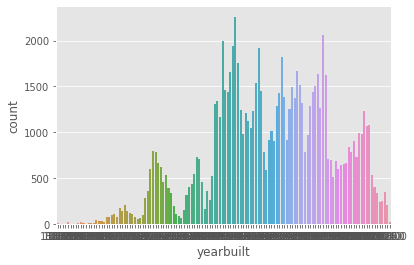

In [94]:
sns.countplot(df_prop_2016.yearbuilt)

In [95]:
print(f"The first year in this series: {df_prop_2016.yearbuilt.min()}")
print(f"The last year in this series: {df_prop_2016.yearbuilt.max()}")

The first year in this series: 1885.0
The last year in this series: 2015.0


In [96]:
print(f"The first year in this series: {df_prop_2017.yearbuilt.min()}")
print(f"The last year in this series: {df_prop_2017.yearbuilt.max()}")

The first year in this series: 1824.0
The last year in this series: 2016.0


Let's make it 13 years a bin. That is, there will be 10 bins.

In [97]:
df_prop_2016.yearbuilt = pd.cut(df_prop_2016.yearbuilt,bins = 10).astype(str) # convert into string object
df_prop_2017.yearbuilt = pd.cut(df_prop_2017.yearbuilt,bins = 10).astype(str) # convert into string object

In [98]:
cat_list.append('yearbuilt')

### Tax Delinquency Year

In [99]:
df_prop_2016.taxdelinquencyyear.value_counts()

14.0    628
15.0    518
13.0    210
12.0    154
10.0     89
11.0     85
9.0      63
8.0      24
7.0       8
6.0       3
99.0      1
Name: taxdelinquencyyear, dtype: int64

In [100]:
df_prop_2017.taxdelinquencyyear.value_counts()

15.0    1560
14.0     801
13.0     187
12.0     113
11.0      98
10.0      66
9.0       47
8.0       14
7.0       10
6.0        1
3.0        1
4.0        1
99.0       1
Name: taxdelinquencyyear, dtype: int64

Since there are too many missing values, let's make it a categorical value, 0 stating missing and 1 stating existing.

In [101]:
df_prop_2016.taxdelinquencyyear = df_prop_2016.taxdelinquencyyear.apply(lambda x: 0 if np.isnan(x) else 1)
df_prop_2017.taxdelinquencyyear = df_prop_2017.taxdelinquencyyear.apply(lambda x: 0 if np.isnan(x) else 1)

In [102]:
cat_list.append('taxdelinquencyyear')

---
### Object Datatype

In [103]:
resume[(resume['dtypes'] == object)]

,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
2,transactiondate,object,0,0.000,352,2016-01-01,2016-01-01,2016-01-01,7.84
24,hashottuborspa,object,87910,97.380,1,NaN,NaN,NaN,0.00
34,propertycountylandusecode,object,1,0.001,77,0100,1,0100,3.20
36,propertyzoningdesc,object,31962,35.405,1996,LARS,NaN,PSR6,7.89
51,fireplaceflag,object,90053,99.754,1,NaN,NaN,NaN,0.00
57,taxdelinquencyflag,object,88492,98.025,1,NaN,NaN,NaN,0.00


### Has Hot Tub or Spa

Definition: **Does the home have a hot tub or spa**

In [104]:
df_prop_2016.hashottuborspa = df_prop_2016.hashottuborspa.replace(np.nan, 'No').replace(True, 'Yes')
df_prop_2017.hashottuborspa = df_prop_2017.hashottuborspa.replace(np.nan, 'No').replace(True, 'Yes')

In [105]:
df_prop_2016.hashottuborspa.value_counts()

No     87910
Yes     2365
Name: hashottuborspa, dtype: int64

In [106]:
df_prop_2017.hashottuborspa.value_counts()

No     76074
Yes     1539
Name: hashottuborspa, dtype: int64

In [107]:
cat_list.append('hashottuborspa')

### Property County Land Use Code

Definition: **County land use code i.e. it's zoning at the county level**

These are all categorical value. Let's make those minor use code into a new code **'Minor'**. Since there's only one missing value, we can also make it into this **'Minor'**.

In [108]:
len(df_prop_2016.propertycountylandusecode.value_counts()), len(df_prop_2017.propertycountylandusecode.value_counts())

(77, 75)

In [109]:
# l = list(df_prop_2016.propertycountylandusecode.value_counts()[23:].index)
# df_prop_2016['propertycountylandusecode'].fillna('Minor', inplace=True)
# for col in l:
#     df_prop_2016['propertycountylandusecode'].replace(col,'Minor',inplace=True)
    
# l = list(df_prop_2017.propertycountylandusecode.value_counts()[23:].index)
# df_prop_2017['propertycountylandusecode'].fillna('Minor', inplace=True)
# for col in l:
#     df_prop_2017['propertycountylandusecode'].replace(col,'Minor',inplace=True)

In [110]:
embed_list.append('propertycountylandusecode')

### Property Zoning Desc

Definition: **Description of the allowed land uses (zoning) for that property**

There are too many unique values in this feature. Let's leave it alone now and put it into the drop_list.

In [113]:
embed_list.append('propertyzoningdesc')

### Fire Place Flag

Definition: **Is a fireplace present in this home.**

In [114]:
df_prop_2016.fireplaceflag = df_prop_2016.fireplaceflag.replace(True,'Yes').replace(np.nan,'No')
df_prop_2017.fireplaceflag = df_prop_2017.fireplaceflag.replace(True,'Yes').replace(np.nan,'No')

In [115]:
df_prop_2016.fireplaceflag.value_counts()

No     90053
Yes      222
Name: fireplaceflag, dtype: int64

In [116]:
cat_list.append('fireplaceflag')

### Tax Delinquency Flag

Definition: **Property taxes for this parcel are past due as of 2015**.

In [117]:
df_prop_2016.taxdelinquencyflag = df_prop_2016.taxdelinquencyflag.replace('Y','Yes').replace(np.nan,'No')
df_prop_2017.taxdelinquencyflag = df_prop_2017.taxdelinquencyflag.replace('Y','Yes').replace(np.nan,'No')

In [118]:
df_prop_2016.taxdelinquencyflag.value_counts()

No     88492
Yes     1783
Name: taxdelinquencyflag, dtype: int64

In [119]:
cat_list.append('taxdelinquencyflag')

In [120]:
df_prop_2016

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,index
0,11016594,0.028,2016-01-01,Central,MissingValue,NaN,2.0,3.0,NaN,upper,...,No,122754.0,360170.0,2015.0,237416.0,6735.88,No,0,6.037e+13,0
1,14366692,-0.168,2016-01-01,No Airconditioning,MissingValue,NaN,3.5,4.0,NaN,MissingValue,...,No,346458.0,585529.0,2015.0,239071.0,10153.02,No,0,NaN,1
2,12098116,-0.004,2016-01-01,Central,MissingValue,NaN,3.0,2.0,NaN,upper,...,No,61994.0,119906.0,2015.0,57912.0,11484.48,No,0,6.037e+13,2
3,12643413,0.022,2016-01-02,Central,MissingValue,NaN,2.0,2.0,NaN,upper,...,No,171518.0,244880.0,2015.0,73362.0,3048.74,No,0,6.037e+13,3
4,14432541,-0.005,2016-01-02,No Airconditioning,MissingValue,NaN,2.5,4.0,NaN,MissingValue,...,No,169574.0,434551.0,2015.0,264977.0,5488.96,No,0,6.059e+13,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90270,10774160,-0.036,2016-12-30,Central,MissingValue,NaN,1.0,1.0,NaN,upper,...,No,43800.0,191000.0,2015.0,147200.0,2495.24,No,0,6.037e+13,90270
90271,12046695,0.007,2016-12-30,No Airconditioning,MissingValue,NaN,3.0,3.0,NaN,upper,...,No,117893.0,161111.0,2015.0,43218.0,1886.54,No,0,6.037e+13,90271
90272,12995401,-0.268,2016-12-30,No Airconditioning,MissingValue,NaN,2.0,4.0,NaN,lower,...,No,22008.0,38096.0,2015.0,16088.0,1925.70,Yes,1,6.037e+13,90272
90273,11402105,0.060,2016-12-30,No Airconditioning,MissingValue,NaN,2.0,2.0,NaN,upper,...,No,132991.0,165869.0,2015.0,32878.0,2285.57,No,0,6.038e+13,90273


In [121]:
num_list = set(df_prop_2016.columns) - set(cat_list).union(set(drop_list))
num_list = set(num_list) - set(embed_list)
num_list.remove('parcelid')
num_list.remove('logerror')
num_list.remove('transactiondate')
num_list.remove('index')

In [122]:
len(cat_list), len(num_list), len(drop_list), len(embed_list)

(16, 25, 9, 7)

有些numerical只有一個unique value可能不是真的numerical

In [123]:
df_prop_2016[num_list].corr()

,threequarterbathnbr,unitcnt,bedroomcnt,landtaxvaluedollarcnt,lotsizesquarefeet,taxvaluedollarcnt,finishedsquarefeet6,yardbuildingsqft26,structuretaxvaluedollarcnt,poolsizesum,...,finishedfloor1squarefeet,finishedsquarefeet13,garagetotalsqft,numberofstories,finishedsquarefeet50,finishedsquarefeet15,calculatedfinishedsquarefeet,basementsqft,yardbuildingsqft17,taxamount
threequarterbathnbr,1.000,NaN,0.111,0.275,5.055e-02,0.355,NaN,NaN,4.104e-01,-0.013,...,NaN,NaN,0.193,-0.042,NaN,NaN,0.320,NaN,NaN,0.351
unitcnt,NaN,1.000e+00,0.178,0.006,-2.859e-02,0.004,0.750,NaN,-9.667e-04,NaN,...,NaN,NaN,-0.191,0.307,NaN,0.558,0.146,NaN,NaN,0.008
bedroomcnt,0.111,1.779e-01,1.000,0.174,-1.147e-01,0.243,-0.320,0.170,3.070e-01,0.104,...,0.458,0.231,0.591,0.151,0.445,0.611,0.634,0.554,0.280,0.240
landtaxvaluedollarcnt,0.275,6.014e-03,0.174,1.000,-3.403e-02,0.955,0.089,-0.012,6.233e-01,0.049,...,0.447,0.030,0.270,0.087,0.446,0.195,0.459,0.124,0.260,0.903
lotsizesquarefeet,0.051,-2.859e-02,-0.115,-0.034,1.000e+00,-0.021,0.158,0.393,8.655e-03,0.002,...,0.353,0.296,0.245,-0.005,0.352,0.125,-0.049,-0.145,0.173,-0.022
taxvaluedollarcnt,0.355,3.914e-03,0.243,0.955,-2.135e-02,1.000,0.159,0.093,8.261e-01,0.093,...,0.556,-0.073,0.362,0.141,0.550,0.288,0.600,0.373,0.308,0.949
finishedsquarefeet6,NaN,7.501e-01,-0.320,0.089,1.583e-01,0.159,1.000,NaN,2.779e-01,NaN,...,NaN,NaN,NaN,0.483,NaN,NaN,1.000,NaN,NaN,0.145
yardbuildingsqft26,NaN,NaN,0.170,-0.012,3.931e-01,0.093,NaN,1.000,1.839e-01,0.041,...,0.271,NaN,0.339,0.079,0.343,NaN,0.282,-0.329,0.126,0.083
structuretaxvaluedollarcnt,0.410,-9.667e-04,0.307,0.623,8.655e-03,0.826,0.278,0.184,1.000e+00,0.155,...,0.597,-0.126,0.431,0.223,0.587,0.423,0.716,0.549,0.317,0.795
poolsizesum,-0.013,NaN,0.104,0.049,2.114e-03,0.093,NaN,0.041,1.548e-01,1.000,...,0.405,NaN,0.211,0.054,0.395,NaN,0.167,0.069,0.286,0.063


In [124]:
df_prop_2016.drop(columns=drop_list, inplace=True)
df_prop_2016.drop(columns=['transactiondate','parcelid','index'], inplace=True)
df_prop_2017.drop(columns=drop_list, inplace=True)
df_prop_2017.drop(columns=['transactiondate','parcelid'], inplace=True)

---
## Feature Engineering

In [125]:
import category_encoders as ce
from statsmodels.imputation import mice

In [126]:
df_prop_2016.head()

,logerror,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,...,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear
0,0.028,Central,NaN,2.0,3.0,upper,NaN,1684.0,1684.0,NaN,...,NaN,"(1950.0, 1963.0]",NaN,No,122754.0,360170.0,237416.0,6735.88,No,0
1,-0.168,No Airconditioning,NaN,3.5,4.0,MissingValue,NaN,2264.0,2264.0,NaN,...,NaN,"(2002.0, 2015.0]",NaN,No,346458.0,585529.0,239071.0,10153.02,No,0
2,-0.004,Central,NaN,3.0,2.0,upper,NaN,2216.0,2216.0,NaN,...,NaN,"(1937.0, 1950.0]",NaN,No,61994.0,119906.0,57912.0,11484.48,No,0
3,0.022,Central,NaN,2.0,2.0,upper,NaN,839.0,839.0,NaN,...,NaN,"(1976.0, 1989.0]",NaN,No,171518.0,244880.0,73362.0,3048.74,No,0
4,-0.005,No Airconditioning,NaN,2.5,4.0,MissingValue,NaN,2284.0,2284.0,NaN,...,NaN,"(1976.0, 1989.0]",2.0,No,169574.0,434551.0,264977.0,5488.96,No,0


In [127]:
# Make sure that datatype in cat_list are all object
df_prop_2016[cat_list] = df_prop_2016[cat_list].astype(object)
df_prop_2017[cat_list] = df_prop_2017[cat_list].astype(object)

In [128]:
# quality check whether there are columns with multiple datatype
types = df_prop_2016.applymap(type).apply(set)
types[types.apply(len) > 1]

propertycountylandusecode    {<class 'float'>, <class 'str'>}
propertyzoningdesc           {<class 'float'>, <class 'str'>}
dtype: object

In [129]:
# be_encoder = ce.BinaryEncoder(verbose = 1, cols = cat_list).fit(df_prop_2016)
# df_prop_2016 = be_encoder.transform(df_prop_2016)

In [130]:
df_prop_2016.sample(10)

,logerror,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,...,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear
60064,-0.088,No Airconditioning,NaN,2.0,3.0,lower,NaN,1049.0,1049.0,NaN,...,NaN,"(1950.0, 1963.0]",NaN,No,163117.0,4.969e+05,3.338e+05,6092.91,No,0
57969,0.039,Central,NaN,1.0,1.0,MissingValue,NaN,716.0,716.0,NaN,...,NaN,"(1976.0, 1989.0]",NaN,No,55449.0,2.750e+05,2.196e+05,3386.44,No,0
88492,-0.043,No Airconditioning,NaN,2.5,5.0,MissingValue,2232.0,2232.0,2232.0,NaN,...,NaN,"(1963.0, 1976.0]",1.0,No,74413.0,9.272e+04,1.831e+04,988.42,No,0
58861,0.004,No Airconditioning,NaN,3.5,4.0,MissingValue,NaN,2912.0,2912.0,NaN,...,NaN,"(1989.0, 2002.0]",NaN,No,453813.0,1.878e+06,1.424e+06,24098.90,No,0
15812,-0.091,No Airconditioning,NaN,1.5,2.0,MissingValue,725.0,1530.0,1530.0,NaN,...,NaN,"(1963.0, 1976.0]",2.0,No,112705.0,1.685e+06,1.573e+06,19272.52,No,0
56960,0.008,Central,NaN,4.0,4.0,best,NaN,3232.0,3232.0,NaN,...,NaN,"(1989.0, 2002.0]",NaN,No,415753.0,8.978e+05,4.820e+05,11141.17,No,0
58339,0.006,No Airconditioning,NaN,1.0,2.0,lower,NaN,1036.0,1036.0,NaN,...,NaN,"(1937.0, 1950.0]",NaN,No,203996.0,4.233e+05,2.193e+05,5232.39,No,0
30653,-0.004,No Airconditioning,NaN,2.0,2.0,lower,NaN,1437.0,1437.0,NaN,...,NaN,"(1924.0, 1937.0]",NaN,No,121071.0,3.723e+05,2.512e+05,4584.83,No,0
74338,0.059,Central,NaN,2.0,2.0,upper,NaN,956.0,956.0,NaN,...,NaN,"(1963.0, 1976.0]",NaN,No,96116.0,2.077e+05,1.116e+05,2686.13,No,0
22246,-0.055,No Airconditioning,NaN,2.0,2.0,lower,NaN,1480.0,NaN,NaN,...,NaN,"(1924.0, 1937.0]",NaN,No,131146.0,5.246e+05,3.934e+05,6546.06,No,0


In [131]:
# quality check whether there are columns with multiple datatype
types = df_prop_2017.applymap(type).apply(set)
types[types.apply(len) > 1]

fips                         {<class 'float'>, <class 'str'>}
propertycountylandusecode    {<class 'float'>, <class 'str'>}
propertyzoningdesc           {<class 'float'>, <class 'str'>}
dtype: object

In [132]:
# be_encoder = ce.BinaryEncoder(verbose = 1, cols = cat_list).fit(df_prop_2017)
# df_prop_2017 = be_encoder.transform(df_prop_2017)

In [133]:
df_prop_2017.sample(10)

,logerror,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,...,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear
30246,-0.005,Central,NaN,3.0,2.0,lower,NaN,1111.0,1111.0,NaN,...,NaN,"(1977.6, 1996.8]",NaN,No,131028.0,4.150e+05,283922.0,4803.88,No,0
40986,-0.006,No Airconditioning,NaN,2.0,3.0,MissingValue,NaN,1548.0,1548.0,NaN,...,NaN,"(1958.4, 1977.6]",1.0,No,94334.0,3.808e+05,286424.0,4606.94,No,0
68835,-0.005,Central,NaN,2.0,3.0,upper,NaN,1225.0,1225.0,NaN,...,NaN,"(1958.4, 1977.6]",NaN,No,46618.0,6.606e+04,19441.0,2477.41,No,0
76385,0.013,No Airconditioning,NaN,2.0,4.0,upper,NaN,1661.0,1661.0,NaN,...,NaN,"(1939.2, 1958.4]",NaN,No,137934.0,3.501e+05,212207.0,4405.70,No,0
21898,0.098,No Airconditioning,NaN,2.5,4.0,MissingValue,2624.0,2624.0,2624.0,NaN,...,NaN,"(1996.8, 2016.0]",1.0,No,157943.0,4.178e+05,259842.0,5098.64,No,0
47648,0.007,No Airconditioning,NaN,2.0,3.0,MissingValue,NaN,1357.0,1357.0,NaN,...,NaN,"(1958.4, 1977.6]",1.0,No,83606.0,3.503e+05,266684.0,4328.78,No,0
26976,-0.013,No Airconditioning,NaN,1.0,3.0,upper,NaN,943.0,943.0,NaN,...,NaN,"(1939.2, 1958.4]",NaN,No,48370.0,6.449e+04,16123.0,1537.61,No,0
62252,-0.016,Central,NaN,3.0,3.0,upper,NaN,1718.0,1718.0,NaN,...,NaN,"(1977.6, 1996.8]",NaN,No,114201.0,1.521e+05,37920.0,2818.39,No,0
39883,-0.039,No Airconditioning,NaN,3.0,4.0,MissingValue,NaN,2188.0,2188.0,NaN,...,NaN,"(1996.8, 2016.0]",NaN,No,310959.0,4.696e+05,158663.0,5631.94,No,0
31974,-0.008,Central,NaN,5.0,5.0,lower,NaN,4128.0,4128.0,NaN,...,NaN,"(1996.8, 2016.0]",NaN,No,603399.0,1.085e+06,481254.0,14224.47,No,0


### MinMaxScaler

In [134]:
from sklearn.preprocessing import MinMaxScaler

In [135]:
df_prop_2016[list(num_list)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   threequarterbathnbr           12009 non-null  float16
 1   unitcnt                       58353 non-null  float16
 2   bedroomcnt                    90275 non-null  float64
 3   landtaxvaluedollarcnt         90274 non-null  float32
 4   lotsizesquarefeet             80125 non-null  float32
 5   taxvaluedollarcnt             90274 non-null  float32
 6   finishedsquarefeet6           421 non-null    float16
 7   yardbuildingsqft26            95 non-null     float16
 8   structuretaxvaluedollarcnt    89895 non-null  float32
 9   poolsizesum                   73343 non-null  float16
 10  roomcnt                       90275 non-null  float16
 11  fireplacecnt                  90275 non-null  float16
 12  bathroomcnt                   90275 non-null  float64
 13  f

In [136]:
df_prop_2016[list(num_list)] = MinMaxScaler().fit_transform(df_prop_2016[list(num_list)])
df_prop_2016[num_list].sample(5)

,threequarterbathnbr,unitcnt,bedroomcnt,landtaxvaluedollarcnt,lotsizesquarefeet,taxvaluedollarcnt,finishedsquarefeet6,yardbuildingsqft26,structuretaxvaluedollarcnt,poolsizesum,...,finishedfloor1squarefeet,finishedsquarefeet13,garagetotalsqft,numberofstories,finishedsquarefeet50,finishedsquarefeet15,calculatedfinishedsquarefeet,basementsqft,yardbuildingsqft17,taxamount
66730,NaN,0.0,0.3,0.004,1.023e-03,0.006,NaN,NaN,0.007,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.071,NaN,NaN,0.043
90163,NaN,0.0,0.4,0.001,6.737e-04,0.004,NaN,NaN,0.008,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.081,NaN,NaN,0.006
12006,NaN,NaN,0.2,0.003,7.754e-04,0.006,NaN,NaN,0.009,0.0,...,0.101,NaN,0.0,0.0,0.092,NaN,0.036,NaN,0.076,0.008
69826,NaN,0.0,0.3,0.004,1.246e-03,0.005,NaN,NaN,0.004,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.061,NaN,NaN,0.093
74710,NaN,0.0,0.3,0.018,1.110e-03,0.019,NaN,NaN,0.011,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.078,NaN,NaN,0.021


In [137]:
df_prop_2017[list(num_list)] = MinMaxScaler().fit_transform(df_prop_2017[list(num_list)])
df_prop_2017[num_list].sample(5)

,threequarterbathnbr,unitcnt,bedroomcnt,landtaxvaluedollarcnt,lotsizesquarefeet,taxvaluedollarcnt,finishedsquarefeet6,yardbuildingsqft26,structuretaxvaluedollarcnt,poolsizesum,...,finishedfloor1squarefeet,finishedsquarefeet13,garagetotalsqft,numberofstories,finishedsquarefeet50,finishedsquarefeet15,calculatedfinishedsquarefeet,basementsqft,yardbuildingsqft17,taxamount
60770,0.0,NaN,0.4,5.469e-04,7.345e-04,0.002,NaN,NaN,0.006,0.0,...,NaN,NaN,0.113,0.2,NaN,NaN,0.055,NaN,NaN,0.002
63160,0.0,NaN,0.4,8.577e-03,8.269e-04,0.012,NaN,NaN,0.015,0.0,...,NaN,NaN,0.146,0.2,NaN,NaN,0.066,NaN,NaN,0.011
56927,NaN,NaN,0.2,5.188e-03,NaN,0.008,NaN,NaN,0.010,0.0,...,NaN,NaN,0.000,NaN,NaN,NaN,0.028,NaN,NaN,0.007
49539,NaN,0.000,0.4,1.904e-03,1.429e-03,0.006,NaN,NaN,0.018,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.049,NaN,NaN,0.007
63136,NaN,0.004,0.6,6.690e-04,7.520e-04,0.002,NaN,NaN,0.005,0.0,...,NaN,NaN,NaN,NaN,NaN,0.058,0.071,NaN,NaN,0.002


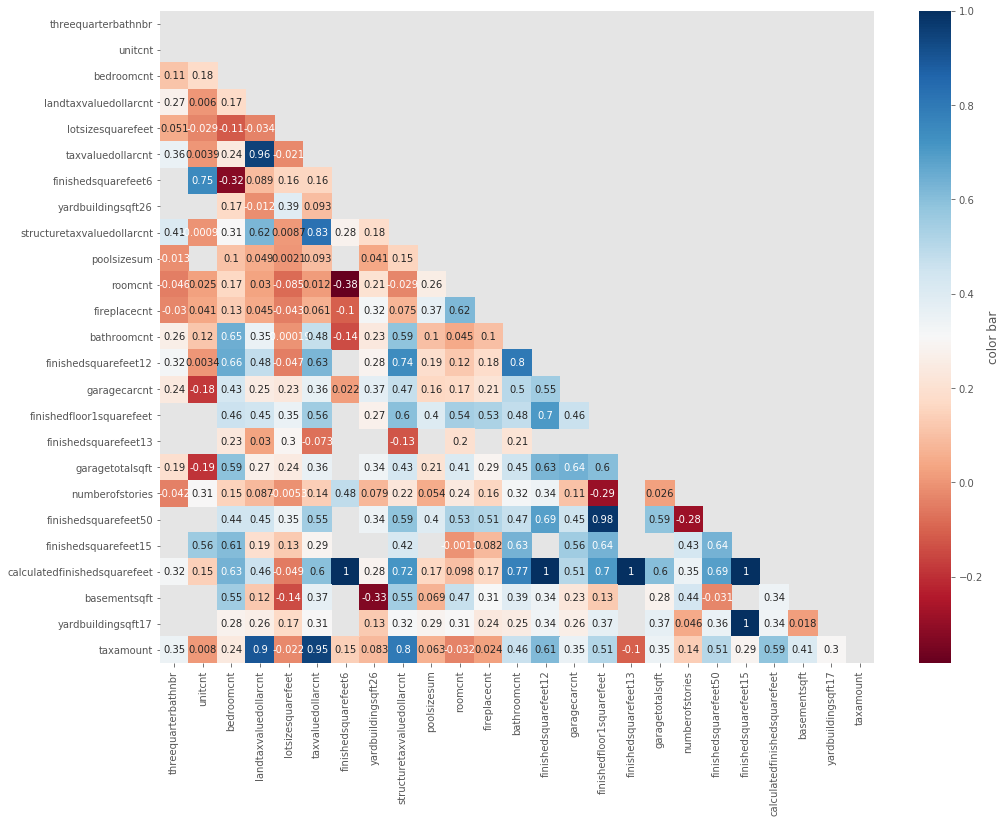

In [138]:
plt.figure(figsize = (16,12))
corr = df_prop_2016[num_list].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True #mask

sns.heatmap(corr, annot=True, cmap='RdBu', 
            mask = mask,
            annot_kws={"size":10}, cbar_kws={"label":"color bar"})

There are certain pairs of value that have extremely high correlation. Let's see what are their definitions.

'calculatedfinishedsquarefeet':  Calculated total finished living area of the home   
'finishedsquarefeet12': Finished living area  
'finishedsquarefeet13': Perimeter  living area  
'finishedsquarefeet15': Total area  
'finishedsquarefeet6': Base unfinished and finished area

In [140]:
df_prop_2016.calculatedfinishedsquarefeet.isna().sum()

661

After several observation, we can see some pattern between these variables.

The feature `calculatedfinishedsquarefeet` is in fact one of the value in the last four feature. Thus, we can drop the  last four features. 

In [141]:
df_prop_2016.drop(columns=['finishedsquarefeet12','finishedsquarefeet13','finishedsquarefeet15','finishedsquarefeet6'], inplace=True)
df_prop_2017.drop(columns=['finishedsquarefeet12','finishedsquarefeet13','finishedsquarefeet15','finishedsquarefeet6'], inplace=True)

Let's also see the relationship between `finishedsquarefeet15` and `yardbuildingsqft17`.

In [142]:
prop_2016[['finishedsquarefeet15','yardbuildingsqft17']].sample(10)

,finishedsquarefeet15,yardbuildingsqft17
631430,NaN,NaN
1098879,NaN,NaN
2856258,NaN,NaN
2275730,NaN,NaN
2813441,NaN,NaN
670448,NaN,NaN
2652541,NaN,NaN
1630042,NaN,NaN
2422588,NaN,NaN
260925,NaN,NaN


After several observation, there are no relationship between the two variables. The cause of the correlation **1** is due to the fact that both features have immense amount of missing values.

Next, let's see the following four variable.

'landtaxvaluedollarcnt': The assessed value of the land area of the parcel  
'taxvaluedollarcnt': The total tax assessed value of the parcel  
'taxamount': The total property tax assessed for that assessment year  
'structuretaxvaluedollarcnt': The assessed value of the built structure on the parcel

In [143]:
prop_2016[['landtaxvaluedollarcnt','taxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt']].sample(5)

,landtaxvaluedollarcnt,taxvaluedollarcnt,taxamount,structuretaxvaluedollarcnt
506097,127144.0,317865.0,3629.52,190721.0
1775561,66501.0,132302.0,1714.16,65801.0
557532,24376.0,98389.0,1353.07,74013.0
2395200,70340.0,187683.0,2424.14,117343.0
676090,146416.0,276643.0,4011.16,130227.0


One interesting fact among these four variables can be shown in the following formula:

$$taxvaluedollarcnt = landtaxvaluedollatcnt + structuretaxvaluedollarcnt$$

From the above heatmap, we can see that `landtaxvaluedollatcnt` and `structuretaxvaluedollarcnt` have moderate relationship.  But what about the relationship between `taxvaluedollarcnt` and `taxamount`?

In [144]:
_ = prop_2016[['taxvaluedollarcnt','taxamount']]
_['rate'] = (_['taxamount'] / _['taxvaluedollarcnt']).apply(lambda x: np.round(x, 3))

In [145]:
_.sample(10)

,taxvaluedollarcnt,taxamount,rate
2515109,623000.0,6846.29,0.011
2623434,354425.0,4922.05,0.014
2805828,294621.0,3692.88,0.013
1433482,821526.0,10036.54,0.012
187075,321293.0,4733.90,0.015
512853,280601.0,3868.57,0.014
1902272,312000.0,3699.66,0.012
1345707,368858.0,5582.65,0.015
803121,293471.0,4507.86,0.015
849512,216905.0,4372.27,0.020


In [146]:
_[_.rate > 0.3].sample(10)

,taxvaluedollarcnt,taxamount,rate
475812,10631.0,3291.01,0.310
1160188,11880.0,13749.96,1.157
966575,24684.0,22755.58,0.922
2665633,35238.0,12498.66,0.355
401282,13000.0,7217.41,0.555
628705,73480.0,26518.40,0.361
416488,101.0,196.23,1.943
539612,40338.0,13304.16,0.330
1832682,23.0,97.07,4.220
758520,28653.0,23342.44,0.815


You can see there are much more ridiculous number of tax rate! We now have no idea what's happening. Thus, let's simply drop `taxvaluedollarcnt` and move on.

In [147]:
df_prop_2016.drop(columns=['taxvaluedollarcnt'], inplace=True)
df_prop_2017.drop(columns=['taxvaluedollarcnt'], inplace=True)

Lastly, let's see the relationship between `finishedsquarefeet50` and `finishedfloor1squarefeet`.

'finishedfloor1squarefeet':  Size of the finished living area on the first (entry) floor of the home

'finishedsquarefeet50': Size of the finished living area on the first (entry) floor of the home

Wait a minute.... This two variables have the same meaning???

In [148]:
prop_2016[['finishedsquarefeet50','finishedfloor1squarefeet']].sample(10)

,finishedsquarefeet50,finishedfloor1squarefeet
1239350,NaN,NaN
2496699,NaN,NaN
850755,NaN,NaN
1169378,NaN,NaN
2781886,NaN,NaN
474005,NaN,NaN
2205145,NaN,NaN
1041803,2140.0,2140.0
847537,NaN,NaN
763422,NaN,NaN


After careful observation we can see that these numbers are the same!

In [149]:
df_prop_2016.drop(columns=['finishedfloor1squarefeet'], inplace=True)
df_prop_2017.drop(columns=['finishedfloor1squarefeet'], inplace=True)

In [150]:
l = ['finishedfloor1squarefeet','taxvaluedollarcnt','finishedsquarefeet12',
     'finishedsquarefeet13','finishedsquarefeet15','finishedsquarefeet6']
for _ in l:
    num_list.remove(_)

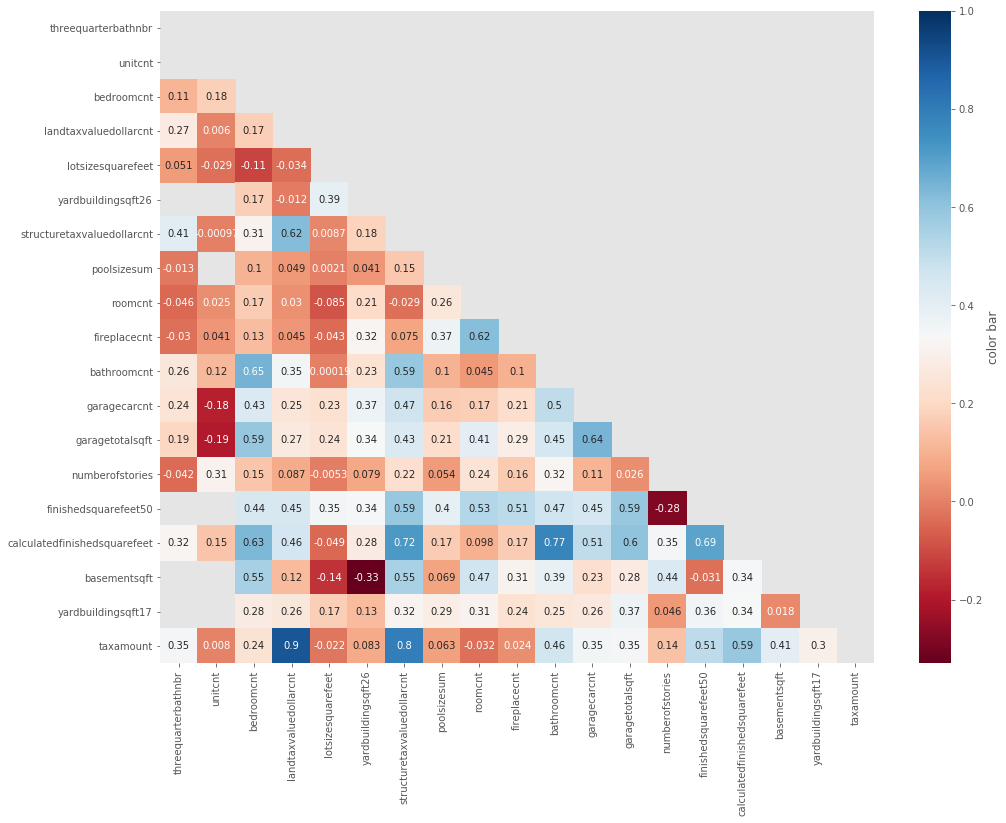

In [151]:
plt.figure(figsize = (16,12))
corr = df_prop_2016[num_list].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True #mask

sns.heatmap(corr, annot=True, cmap='RdBu', 
            mask = mask,
            annot_kws={"size":10}, cbar_kws={"label":"color bar"})